In [150]:
library(tidyverse)
library(patchwork)

## Why Use K-Fold?

We've learned about 3 types of model validation: *Train-Test-Split*, *K-Fold*, and *Leave-One-Out* (which is just an extreme version of K-Fold).

**Train-Test-Split** is a model validation method in which you set aside a certain percentage of your data to use as a test set. The reserved test set is used to estimate your model's out-of-sample performance.

**K-Fold** is a model validation method in which you split your data into *k* equally sized folds. You then build *k* models. Each model is built using *k-1* of the folds, with the remaining fold acting as the test set. This allows you to use every single data point in your dataset (at one point or another) to estimate the out-of-sample performance.

**Leave One Out** is a model validation method that takes K-Fold to the nth degree. In LOO, each data point is its own fold. This means you will fit *n* (the number of data points) models, with each model being trained using *n-1* data points. Out-of-sample performance is estimated using the 1 reserved data point. 

TTS is easy, and computationally inexpensive, so why use K-Fold? One reason we discussed is that K-Fold allows you to use ALL your data in the test-set, and all your data in the training-set at (at least) one point.

Use the simulation below to look at how well TTS vs KF estimate the out-of-sample (test-set) error.

In [146]:
modelValidationSim <- function(n = 100, error_sd = 1){

    mse <- function(true,pred){
        return(mean((true - pred)**2))
    }

    # Simulate Data
    # ---mean cat length in cm  
    mean_length_cm <- 170

    # ---standard deviation of cat length in cm
    sd_length_cm <- 15

    # ---generate random data for cat length that follows a normal distribution
    length <- rnorm(n, mean_length_cm, sd_length_cm)

    # ---weight = intercept + length*coefficient + random error
    weight <- 0.2 + length*0.04 + rnorm(n,0,error_sd)


    cats <- data.frame(length = length, weight = weight)

    ##############################################
    # Build a model using a Train Test Split with 20% (1/5th) of data in the test set
    test <- 0.2

    # choose which rows are in the test set
    test_indices <- sample(1:nrow(cats), round(nrow(cats)*test), replace = FALSE)

    lrTTS <- lm(weight ~ length, data = cats[-test_indices,])


    # Store the test-set MSE in the variable TTS
    TTS_mse <- mse(cats[test_indices,]$weight,
                   predict(lrTTS, data.frame(length = cats[test_indices,]$length)))

    ##############################################
    # Build a model using a 5-Fold CV
    k <- 5

    # partition indices into k groups
    folds <- split(1:nrow(cats), ceiling(seq_along(1:nrow(cats))/(n/k)))

    models <- lapply(folds, function(x) lm(weight ~ length, data = cats[-x,]))



    mses <- mapply(function(x,y) mse(cats[y,]$weight,
                                     predict(x, newdata = data.frame(length = cats[y,]$length))),
                  x = models, y = folds)

    # Store the average test-set MSE in the variable KF

    KF_mse = mean(mses) ###

    ##############################################

    # Return a dataframe with the KFold as one Column, and TrainTestSplit as the other (the df should have just 1 row)

    ##############################################

    df <- data.frame(Kfold = KF_mse, TrainTestSplit = TTS_mse)


        return(df)

}





### *Question*

* In the cell below, use list comprehension to run this simulation 500 times.
* Then use ggplot to plot the histograms (or I highly recommend densities `geom_density(alpha = 0.4)` if you wanna get fancy) of the estimated MSE's from TTS vs KFold (look up `pivot_longer()` to get your data in long form for this one)
* Plot a scatterplot of the TTS vs KFold estimates
* What patterns do you see? Is TTS systematically different from KFold? How could any differences you see affect your interpretation of TTS vs KF, or affect which you choose to use?
* Try changing `error_sd` (the standard deviation of the random error we add to the simulated data. The larger `error_sd` is, the more spread out data will be around the regression line), does this change the mean squared error estimates? Is there a certain pattern you can see?
* change `n` (the number of samples) to be 1000. Does this change anything? Change the difference between KF and TTS?

<img src="https://drive.google.com/uc?export=view&id=1gquRjmDWGDbuNSqcgVJ-py11VoxrfEJf" width = 200px />


In [147]:
n <- 10000
dfs <- lapply(1:10000, function(x) modelValidationSim(n = n))
dfs_concat <- do.call(rbind,dfs)
dfs_long <- dfs_concat %>% pivot_longer(c("Kfold", "TrainTestSplit"), names_to = "method", values_to = "mse")

In [151]:
options(repr.plot.width=10, repr.plot.height=5) # make the plot wide

n_10000 <- ggplot(dfs_long, aes(x = mse, fill = method)) + geom_density(alpha = 0.4, color = "black") +
 theme_minimal() + labs(x = paste0("Mean Squared Errors (From ",n," simulations)"), y = "",
                        title = paste0("Distributions of MSEs from ", n, " simulated datasets"),
                        subtitle = "(dashed line represents true out-of-sample error)") +
geom_vline(xintercept = 1, lty = "dashed", size = 2, color = "black") + 
xlim(c(-1,3)) +
theme(axis.text.y = element_blank(),
     panel.grid.major.y = element_blank(),
     panel.grid.minor.y = element_blank())

In [152]:
n <- 100
dfs <- lapply(1:10000, function(x) modelValidationSim(n = n))
dfs_concat <- do.call(rbind,dfs)
dfs_long <- dfs_concat %>% pivot_longer(c("Kfold", "TrainTestSplit"), names_to = "method", values_to = "mse")

In [153]:
options(repr.plot.width=10, repr.plot.height=5) # make the plot wide

n_100 <- ggplot(dfs_long, aes(x = mse, fill = method)) + geom_density(alpha = 0.4, color = "black") +
 theme_minimal() + labs(x = paste0("Mean Squared Errors (From ",n," simulations)"), y = "",
                        title = paste0("Distributions of MSEs from ", n, " simulated datasets"),
                        subtitle = "(dashed line represents true out-of-sample error)") +
geom_vline(xintercept = 1, lty = "dashed", size = 2, color = "black") + 
xlim(c(-1,3)) +
theme(axis.text.y = element_blank(),
     panel.grid.major.y = element_blank(),
     panel.grid.minor.y = element_blank())

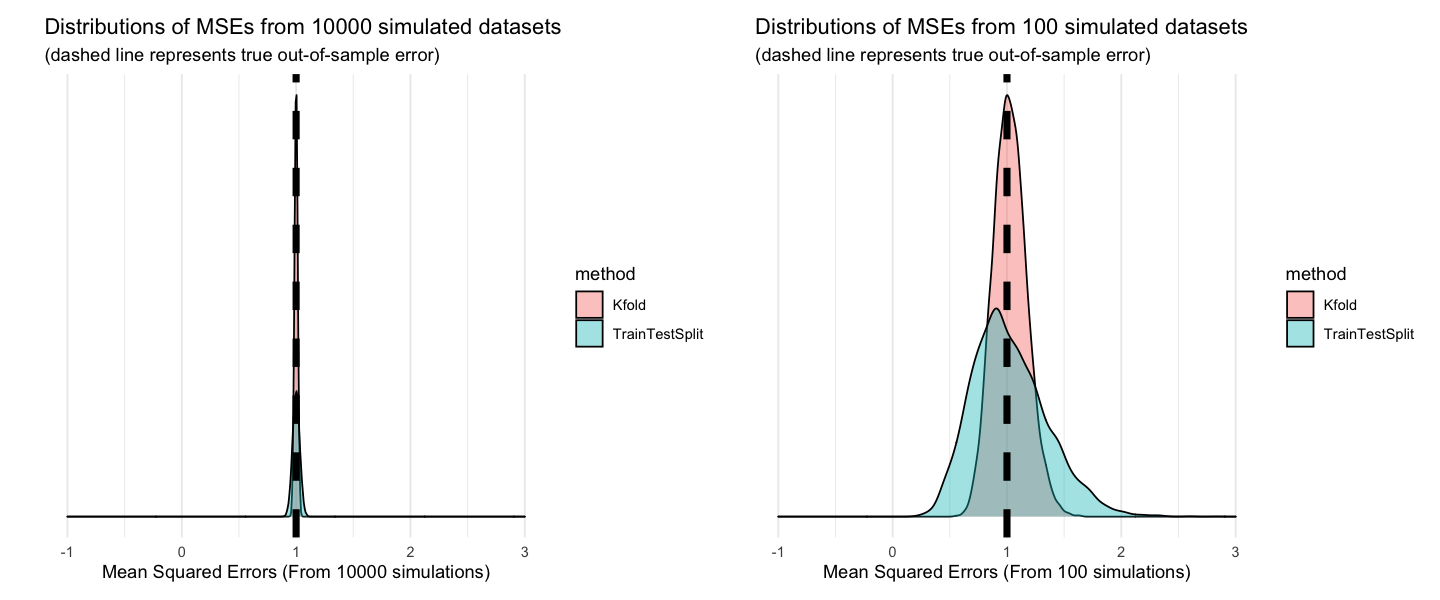

In [155]:
options(repr.plot.width=12, repr.plot.height=5) # make the plot wide

n_10000 + n_100